In [1]:
# Library necessary to transform every doc in a vector

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# Library necessary to make the lemmatization and to import a list of stopwords

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Some homebrew modules to pre-process the data

import getpdf_2

# PCA
from sklearn.decomposition import TruncatedSVD

# Doc2vec

from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from sklearn.model_selection import train_test_split

import os,os.path,sys

C:\Users\Felipe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Text structure

Each one of the texts in Paper's folder has the following structure:

1. Title
2. Authors' names
3. Miscellaneous' informations about the authors (e-mail, university, etc)
4. Abstract
5. References

The text is labeled by the initial uppercase leters in its filename. So, for example, 'CBR-837Cha221-233' is classified as a CBR document.

## tsne_txt function
The function defined as tsne_txt aplies the t-sne tecnique to this set of documents. It uses three possible segmentations of each text:

1. full: every character of the text is used
2. abstract: only the abstract is used
3. abs_ref: the abstract and the reference are used
4. references: the reference is used
5. title: only the title is used

The only parameter of the function is one of the 5 above options. So, to use only the abstract of the text in the analysis, you have to enter __tsne(segmentation='abstract')__.


In [2]:
# função que utiliza a técnica de t-sne para reduzir a dimensionalidade dos textos.

def tsne_txt(tec='tfidf', dim_reduction='svd'):
    
    tudo=getpdf_2.agregar_dict('2019')
    mega_dic=getpdf_2.ultimato(tudo)
    df_data,discursos,dic_discursos,dic_quantidade=getpdf_2.discurso_concatenado(mega_dic)
    
    

    
    class StemTokenizer(object): # A class to stem the words of each doc
                                 
        def __init__(self):
            self.stemmer=SnowballStemmer('portuguese')
        def __call__(self,doc):
            return [self.stemmer.stem(t) for t in RegexpTokenizer(r'\w+').tokenize(doc)]
            
    StopWords=set(stopwords.words('portuguese'))
    add_stopwords=['aquel', 'aquil', 'del', 'depo', 'estam', 'estav', 'estej', 'estev', 'estiv', 'estivéss','estáv',\
                    'estã', 'fom', 'form','foss', 'fôr', 'fôss', 'haj', 'hav', 'houv', 'houvéss', 'hã', 'mesm', 'minh',\
                    'muit', 'noss', 'nã', 'par', 'pel','quand','sej', 'ser', 'serã', 'som', 'sã', 'tenh', 'ter', 'terã',\
                    'tev', 'tinh', 'tiv', 'tivéss', 'tính', 'voc', 'éram','dep','presidente','president']
    
    
    
    
    
    for word in add_stopwords:
        StopWords.add(word)
            
    if tec=='tfidf':
        # Implementing tdidf in the data
        
        tfidf_count_vec=TfidfVectorizer(encoding='latin-1',stop_words=StopWords,tokenizer=StemTokenizer())
        tfidf_papers=tfidf_count_vec.fit_transform(discursos)
        
        sumary=[len(discursos)]
        sumary.append(tfidf_papers.shape) #adds to sumary the tfidf dimention
        
        if dim_reduction=='svd': # uses pca to reduce the dimensionality
            dim=0
            componentes=536
            t=0
            while dim<0.95:
                
                svd=TruncatedSVD(n_components=componentes)
                svd.fit(tfidf_papers)
                dim=svd.explained_variance_ratio_.sum()
                componentes+=1
                t+=1
                print(t)
            
            svd=TruncatedSVD(n_components=componentes)
            dense_tfidf=svd.fit_transform(tfidf_papers)
            sumary.append(dense_tfidf.shape)
            
        else:                                  # TfidfVectorizer() outputs a sparse matrix. To utilize t-sne, we need a more robust one
            
            dense_tfidf=tfidf_papers.toarray() # One problem: it probably produces some random noise in the classification
        
        tsne=TSNE(perplexity=5)
        tsne_papers=tsne.fit_transform(dense_tfidf)
        df_data['tsne-2d-one']=tsne_papers[:,0]
        df_data['tsne-2d-two']=tsne_papers[:,1]
    
        plt.figure(figsize=(16,10))
        
    
        sns.scatterplot(data=df_data,hue='Bancada',
                        x='tsne-2d-one',y='tsne-2d-two')
        
        
        
        return df_data,discursos,dic_discursos,dic_quantidade
    
    elif tec=='doc2vec':
        return 0
        
      


Sessão


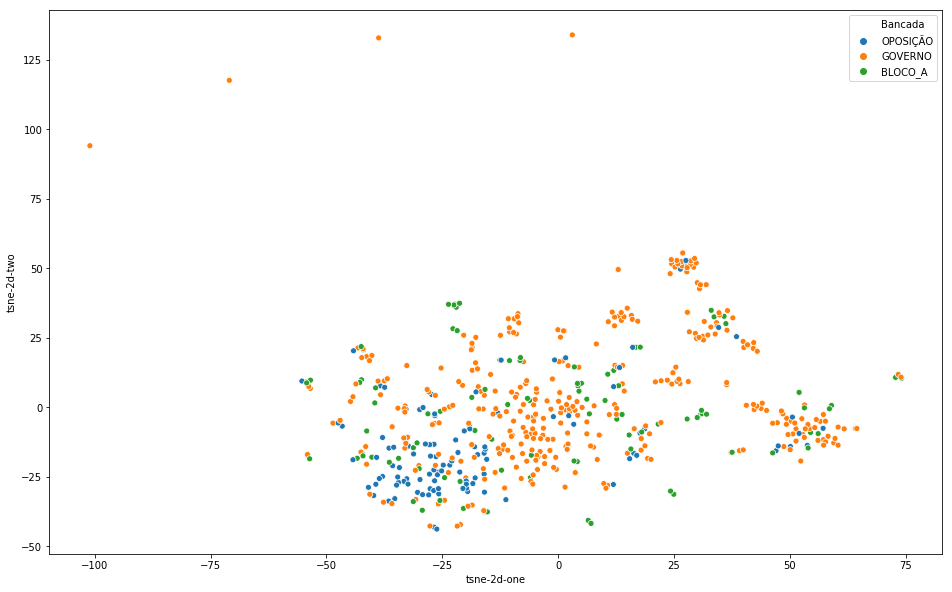

In [3]:
path=r'D:\EMAP\Fundamentos Data Science\Data2'
file='2019_7_12_Sessão_Extraordinária__0931.pdf'
file2='2018_9_4_Sessão_Extraordinária__0931.pdf'
file3='2019_4_17_Sessão_Solene__0930'
filename=os.path.join(path,file)

a,b,c,d=tsne_txt(tec='tfidf', dim_reduction='sfvd')

In [8]:
a[a['tsne-2d-two']<-75]

,Nome,Partido,Bancada,Estado,Discurso,Quantidade,Ordem,tsne-2d-one,tsne-2d-two
477,ABOU ANNI,PSL,GOVERNO,SP,"- Assim o prometo.\n\nO - Obrigado, Sr. Pres...",5906,"[649, 77, 78, 79, 80, 33]",86.336517,-111.736153
485,ADRIANO DO BALDY,PP,GOVERNO,GO,- O Deputado Adriano do Baldy\nvotou conforme...,98,"[285, 813, 196]",-67.538445,-131.884125
500,LOURIVAL GOMES,PSL,GOVERNO,RJ,- Assim o prometo.\n\nO - Quero saudar o Pre...,436,"[611, 117, 173]",37.598392,-142.882248
